# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [14]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
data_train, data_test

(Dataset SVHN
     Number of datapoints: 73257
     Root location: ./data/
     Split: train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
            ),
 Dataset SVHN
     Number of datapoints: 26032
     Root location: ./data/
     Split: test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
            ))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [23]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [27]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
print("SVHN data sample label: ", label)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)
    
sample.shape, sample.view(sample.shape[0], -1).shape

SVHN data sample shape:  torch.Size([3, 32, 32])
SVHN data sample label:  1


(torch.Size([3, 32, 32]), torch.Size([3, 1024]))

И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [28]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [29]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.825082, Train accuracy: 0.411152, Val accuracy: 0.545901
Average loss: 1.458349, Train accuracy: 0.582347, Val accuracy: 0.584533
Average loss: 1.377262, Train accuracy: 0.619971, Val accuracy: 0.628080


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [30]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.174730, Train accuracy: 0.202744, Val accuracy: 0.241485
Average loss: 2.004994, Train accuracy: 0.276422, Val accuracy: 0.301481
Average loss: 1.855372, Train accuracy: 0.337440, Val accuracy: 0.374991
Average loss: 1.746388, Train accuracy: 0.396802, Val accuracy: 0.404955
Average loss: 1.693109, Train accuracy: 0.422363, Val accuracy: 0.414374


Добавьте слой с Batch Normalization

In [31]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.056712, Train accuracy: 0.316845, Val accuracy: 0.420790
Average loss: 1.766929, Train accuracy: 0.460908, Val accuracy: 0.508429
Average loss: 1.630706, Train accuracy: 0.533648, Val accuracy: 0.569313
Average loss: 1.545179, Train accuracy: 0.576187, Val accuracy: 0.593407
Average loss: 1.491520, Train accuracy: 0.599256, Val accuracy: 0.622620


Добавьте уменьшение скорости обучения по ходу тренировки.

In [232]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step() # Decay learning rate
        
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("LR: %f, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (scheduler.get_lr()[0], ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [233]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 6)

LR: 0.000125, Average loss: 2.078994, Train accuracy: 0.301181, Val accuracy: 0.422633
LR: 0.000031, Average loss: 1.772088, Train accuracy: 0.471931, Val accuracy: 0.532046


KeyboardInterrupt: 

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [207]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    val_sampler = SubsetSampler(indices)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                             sampler=val_sampler)
    predictions = []
    ground_truth = []
    for i_step, (x, y) in enumerate(val_loader):
        prediction = model(x)
        prediction_y = torch.argmax(prediction, 1)
        predictions += prediction_y.tolist()
        ground_truth += y.tolist()
    
    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))
predictions, predictions.shape, gt, gt.shape

(array([1, 4, 6, ..., 6, 3, 5]),
 (14651,),
 array([1, 4, 6, ..., 6, 3, 3]),
 (14651,))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

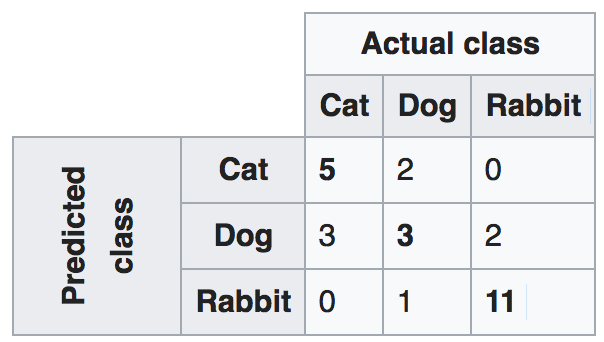

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

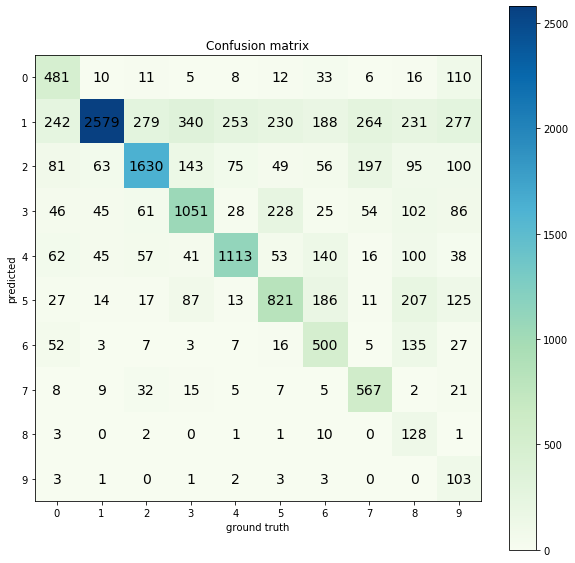

In [222]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    # TODO: Implement filling the prediction matrix
    gt_classes = np.arange(10)[:,None] == ground_truth 
    pred_classes = np.arange(10)[:,None] == predictions
    confusion_matrix = np.sum(np.logical_and(pred_classes[:, None], gt_classes), 2)
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

assert gt.shape[0] == np.sum(confusion_matrix)
assert np.sum(gt == 9) == np.sum(confusion_matrix[:,9])
assert np.sum(gt == 1) == np.sum(confusion_matrix[:,1])
assert np.sum(predictions == 7) == np.sum(confusion_matrix[7])
assert np.sum(predictions == 3) == np.sum(confusion_matrix[3])

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

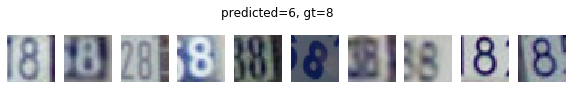

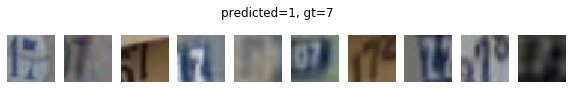

In [231]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices = val_indices[np.logical_and(predictions == predicted_class, groud_truth == gt_class)]
    visualize_images(indices, data, 'predicted=%d, gt=%d' % (predicted_class, gt_class))

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [266]:
def evaluate_model(model, loader):
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        loss_value = loss(prediction, y)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
        loss_accum += loss_value
    ave_loss = loss_accum / (i_step + 1)
    accuracy = float(correct_samples) / total_samples
    return accuracy, ave_loss

def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    train_loss_history = []
    val_loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss_value
        train_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
    
        val_accuracy, val_loss = evaluate_model(model, val_loader)
        
        train_loss_history.append(float(train_loss))
        val_loss_history.append(float(val_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        scheduler.step(val_loss) # Decay learning rate
        
        def get_lr(optimizer):
            for param_group in optimizer.param_groups:
                return param_group['lr']
        
        print("Epoch:%d, LR: %f, Train loss: %f, Val loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), train_loss, val_loss, train_accuracy, val_accuracy))
        
    return train_loss_history, val_loss_history, train_history, val_history

In [267]:
%%time

batch_size = 64
num_epochs = 100
num_neurons = 128
image_size = 3*32*32
output_classes = 10

lr = 1e-3

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0.01)

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(image_size, num_neurons),
            nn.BatchNorm1d(num_neurons),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(inplace=True),
            nn.Linear(num_neurons, num_neurons),
            nn.BatchNorm1d(num_neurons),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(inplace=True),
            nn.Linear(num_neurons, output_classes), 
         )
nn_model.apply(init_weights)

optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=1e-7)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, threshold=1e-2, patience=4)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

train_loss_history, val_loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs)

Epoch:0, LR: 0.001000, Train loss: 2.105911, Val loss: 1.472400, Train accuracy: 0.275620, Val accuracy: 0.555593
Epoch:1, LR: 0.001000, Train loss: 1.568023, Val loss: 1.226648, Train accuracy: 0.469338, Val accuracy: 0.642823
Epoch:2, LR: 0.001000, Train loss: 1.412982, Val loss: 1.089842, Train accuracy: 0.535679, Val accuracy: 0.680636
Epoch:3, LR: 0.001000, Train loss: 1.323994, Val loss: 1.013150, Train accuracy: 0.571494, Val accuracy: 0.703433
Epoch:4, LR: 0.001000, Train loss: 1.260947, Val loss: 0.960243, Train accuracy: 0.593984, Val accuracy: 0.721998
Epoch:5, LR: 0.001000, Train loss: 1.217274, Val loss: 0.887770, Train accuracy: 0.610467, Val accuracy: 0.745478
Epoch:6, LR: 0.001000, Train loss: 1.177073, Val loss: 0.881508, Train accuracy: 0.625550, Val accuracy: 0.747048
Epoch:7, LR: 0.001000, Train loss: 1.150648, Val loss: 0.845468, Train accuracy: 0.635191, Val accuracy: 0.754966
Epoch:8, LR: 0.001000, Train loss: 1.123234, Val loss: 0.820524, Train accuracy: 0.64182

Epoch:72, LR: 0.000016, Train loss: 0.868941, Val loss: 0.610316, Train accuracy: 0.727076, Val accuracy: 0.825404
Epoch:73, LR: 0.000016, Train loss: 0.861678, Val loss: 0.597786, Train accuracy: 0.730267, Val accuracy: 0.825609
Epoch:74, LR: 0.000016, Train loss: 0.865350, Val loss: 0.603454, Train accuracy: 0.727673, Val accuracy: 0.826087
Epoch:75, LR: 0.000016, Train loss: 0.861480, Val loss: 0.599662, Train accuracy: 0.730813, Val accuracy: 0.829227
Epoch:76, LR: 0.000016, Train loss: 0.864971, Val loss: 0.606012, Train accuracy: 0.729789, Val accuracy: 0.827316
Epoch:77, LR: 0.000016, Train loss: 0.865979, Val loss: 0.599732, Train accuracy: 0.729192, Val accuracy: 0.826974
Epoch:78, LR: 0.000008, Train loss: 0.863663, Val loss: 0.604417, Train accuracy: 0.728936, Val accuracy: 0.825131
Epoch:79, LR: 0.000008, Train loss: 0.863274, Val loss: 0.601594, Train accuracy: 0.730062, Val accuracy: 0.826360
Epoch:80, LR: 0.000008, Train loss: 0.861463, Val loss: 0.599608, Train accuracy

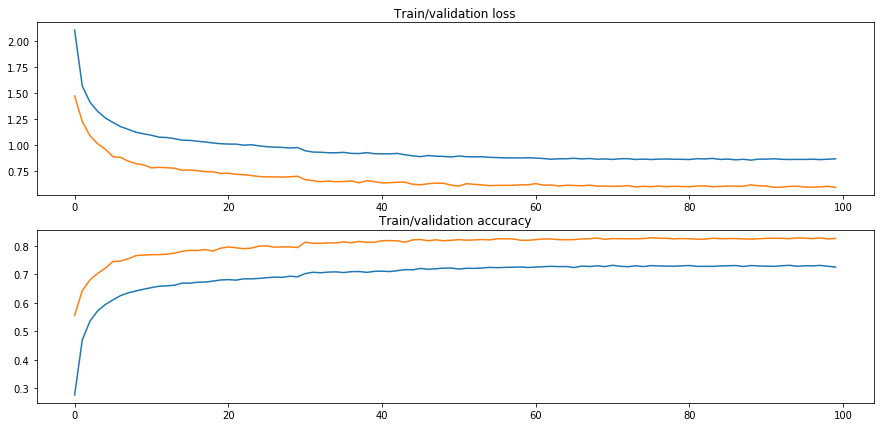

In [268]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Train/validation loss")
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [269]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8037
